In [1]:
'''
Initial Data Exploration
'''
import os
import tarfile


#seabass exploration
os.rename('0c233b5a95_documents.tgz.sb', '0c233b5a95_documents.tgz')
!ls /content/

0c233b5a95_CAML_cyanobacteria_abundance_20211229_R1.sb	0c233b5a95_documents.tgz  sample_data


In [2]:
#grabbing the dataset metadata
with tarfile.open('0c233b5a95_documents.tgz', 'r:gz') as tar:
    tar.extractall('extracted_contents')
extracted_files = os.listdir('extracted_contents')

print(extracted_files)

['documents']


In [3]:
import pandas as pd

#grab the actual cyano dataset from the noaa
file_path = './0c233b5a95_CAML_cyanobacteria_abundance_20211229_R1.sb'

#skip the header
with open(file_path, 'r') as file:
    lines = file.readlines()
start_line = None
for i, line in enumerate(lines):
    if '/end_header' in line:
        start_line = i + 1
        break
if start_line is None:
    raise ValueError("The '/end_header' marker was not found in the file.")

#create columns
columns = [
    "uid", "data_provider", "region", "lat", "lon",
    "date", "time", "abun", "severity", "distance_to_water_m"
]

#put data into dataframe
df = pd.read_csv(file_path, skiprows=start_line, delimiter=',', names=columns)

#convert the types
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')  # Convert date to datetime
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.time  # Convert time to time object
df['abun'] = pd.to_numeric(df['abun'], errors='coerce')  # Convert abundance to numeric
df['severity'] = pd.to_numeric(df['severity'], errors='coerce')  # Convert severity to numeric
df['distance_to_water_m'] = pd.to_numeric(df['distance_to_water_m'], errors='coerce')  # Convert distance to numeric

#see if correctly grabbed
print("Data Loaded Successfully!")
print(df.head())
print("\nData Types and Non-Null Counts:")
print(df.info())




Data Loaded Successfully!
    uid                                      data_provider   region  \
0  aabm                 Indiana_State_Department_of_Health  midwest   
1  aabn     California_Environmental_Data_Exchange_Network     west   
2  aacd  NC_Division_of_Water_Resources_NC_Department_o...    south   
3  aaee  NC_Division_of_Water_Resources_NC_Department_o...    south   
4  aaff  Bureau_of_Water_Kansas_Department_of_Health_an...  midwest   

         lat         lon       date      time      abun  severity  \
0  39.080319  -86.430867 2018-05-14  15:00:00     0.585         1   
1  36.559700 -121.510000 2016-08-31  16:15:00  5867.500         4   
2  35.875083  -78.878434 2020-11-19  00:01:00     0.290         1   
3  35.487000  -79.062133 2016-08-24  00:01:00     1.614         1   
4  38.049471  -99.827001 2019-07-23  00:01:00   111.825         3   

   distance_to_water_m  
0                  0.0  
1               3512.0  
2                514.0  
3                129.0  
4      

In [4]:
import numpy as np

metadata_file_path = 'metadata.csv'

#making the metadata from NOAA
metadata = df[['uid', 'lat', 'lon', 'date']].copy()  #grab metadata cols
metadata.rename(columns={'lat': 'latitude', 'lon': 'longitude'}, inplace=True)

#add data split
np.random.seed(42)
metadata['split'] = np.random.choice(['train', 'test'], size=len(metadata), p=[0.71, 0.29])
metadata.to_csv(metadata_file_path, index=False)

print(f"Metadata file saved to {metadata_file_path}.")
print(metadata.head())

Metadata file saved to metadata.csv.
    uid   latitude   longitude       date  split
0  aabm  39.080319  -86.430867 2018-05-14  train
1  aabn  36.559700 -121.510000 2016-08-31   test
2  aacd  35.875083  -78.878434 2020-11-19   test
3  aaee  35.487000  -79.062133 2016-08-24  train
4  aaff  38.049471  -99.827001 2019-07-23  train


In [5]:
labels_file_path = 'labels_to_be_trained.csv'

#grab metadata
metadata = pd.read_csv(metadata_file_path)
train_metadata = metadata[metadata['split'] == 'train']
train_labels = df[['uid', 'region', 'severity', 'abun']].merge(train_metadata[['uid']], on='uid')
train_labels.rename(columns={'abun': 'abundance'}, inplace=True)
train_labels.to_csv(labels_file_path, index=False)

print(f"Labels file for training split saved to {labels_file_path}.")
print(train_labels.head())

Labels file for training split saved to labels_to_be_trained.csv.
    uid   region  severity  abundance
0  aabm  midwest         1      0.585
1  aaee    south         1      1.614
2  aaff  midwest         3    111.825
3  aafl  midwest         4   2017.313
4  aafp    south         1      1.594


In [6]:
#splitting training and testing
training_set = metadata[metadata['split'] == 'train'].copy()
testing_set = metadata[metadata['split'] == 'test'].copy()

training_set = training_set.merge(train_labels, on='uid')
training_set.head(10)

,uid,latitude,longitude,date,split,region,severity,abundance
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,0.585000
1,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1.614000
2,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111.825000
3,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017.313000
4,aafp,35.647742,-79.271782,2017-11-15,train,south,1,1.594000
5,aahy,35.726522,-79.125458,2014-08-12,train,south,1,6.100000
6,aaia,35.980000,-78.791686,2018-06-27,train,south,1,16.943000
7,aaie,35.861325,-78.768321,2013-11-06,train,south,2,22.822000
8,aajk,37.746680,-97.779360,2021-10-18,train,midwest,1,13.119000
9,aajw,40.703968,-80.293050,2015-08-26,train,northeast,1,2.451087


Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16711 entries, 0 to 16710
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uid        16711 non-null  object 
 1   latitude   16711 non-null  float64
 2   longitude  16711 non-null  float64
 3   date       16711 non-null  object 
 4   split      16711 non-null  object 
 5   region     16711 non-null  object 
 6   severity   16711 non-null  int64  
 7   abundance  16711 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.0+ MB

Basic Statistics:

           latitude     longitude      severity      abundance
count  16711.000000  16711.000000  16711.000000   16711.000000
mean      37.617676    -91.434591      2.245048    1261.940275
std        2.827502     17.878232      1.238750    7002.118560
min       26.389430   -124.179200      1.000000       0.000000
25%       35.700959   -109.432050      1.000000       4.214569
50%       36.324700 

<ipython-input-7-aea529448f88>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=training_set, x='severity', palette='viridis')


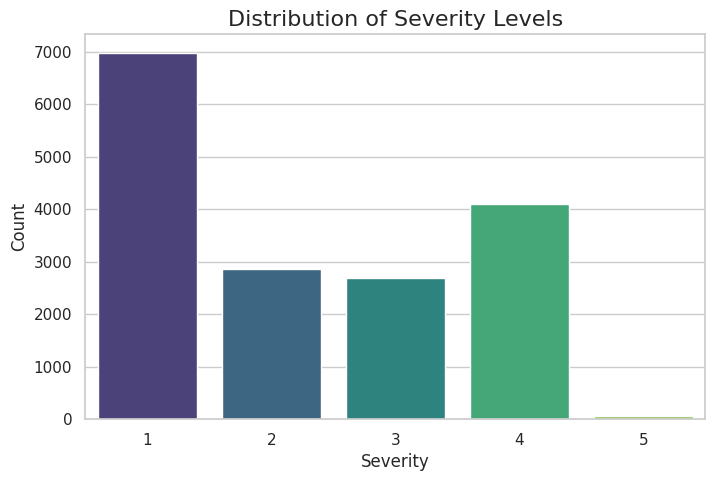

<ipython-input-7-aea529448f88>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=training_set, x='region', y='severity', palette='pastel')


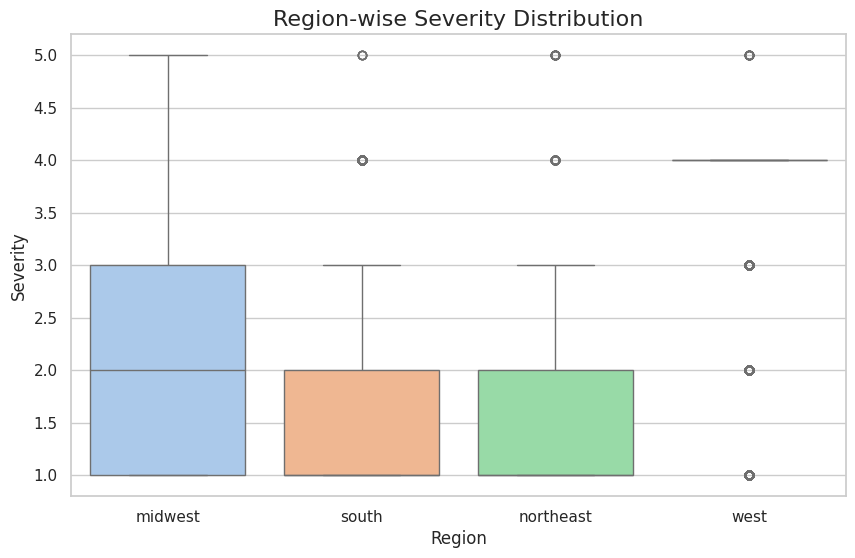

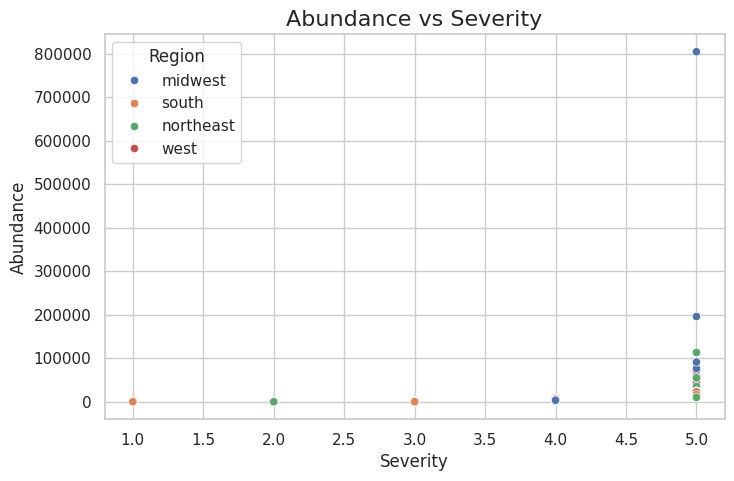

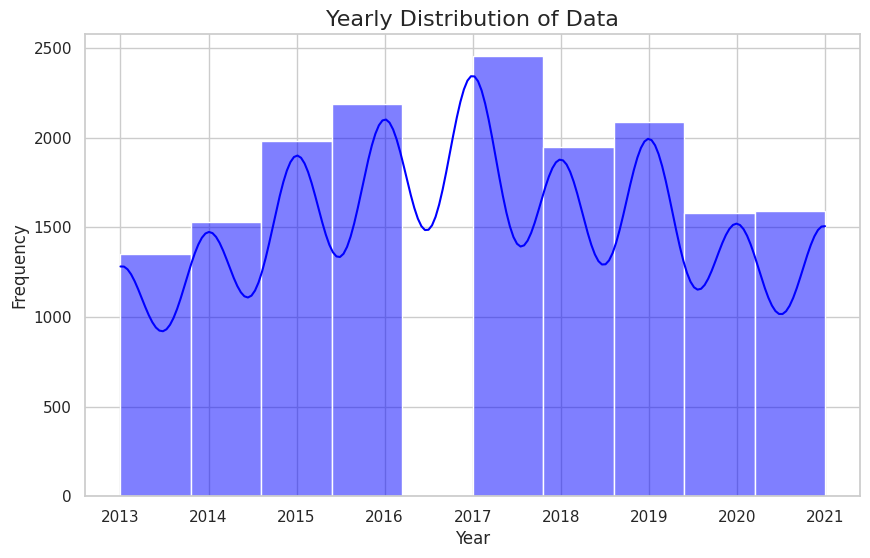

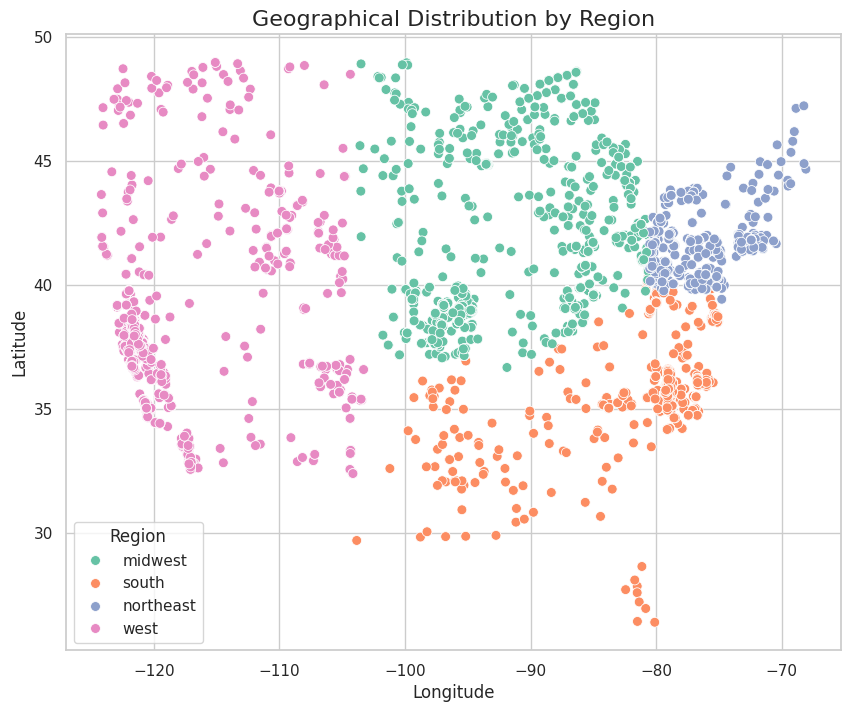

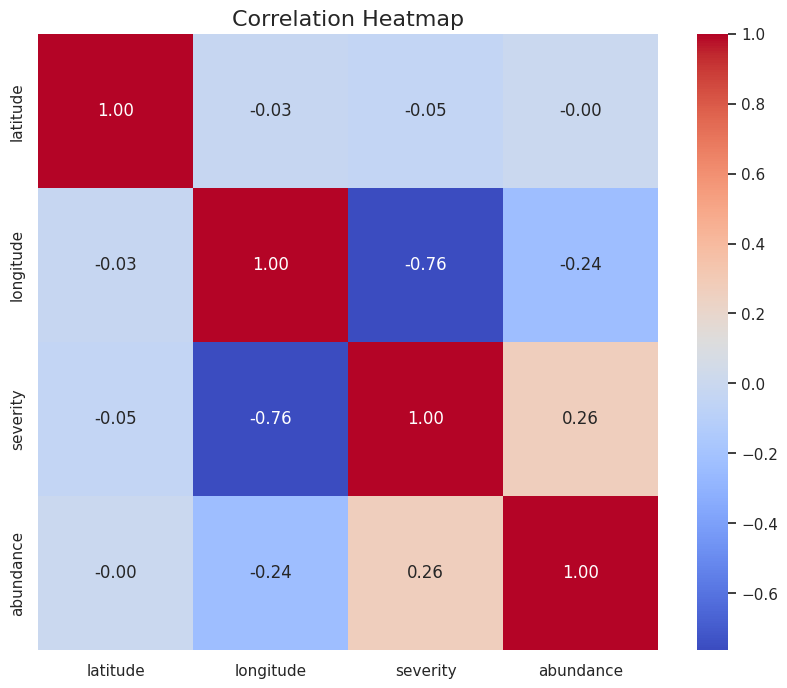


Mean Abundance by Region and Severity:

       region  severity     abundance
0     midwest         1      4.026839
1     midwest         2     51.909437
2     midwest         3    350.423126
3     midwest         4   2458.594701
4     midwest         5  99016.125667
5   northeast         1      4.578593
6   northeast         2     48.330378
7   northeast         3    296.863912
8   northeast         4   2428.708203
9   northeast         5  26483.133824
10      south         1      5.366562
11      south         2     48.086347
12      south         3    300.722334
13      south         4   2067.590813
14      south         5  15965.013600
15       west         1      4.653747
16       west         2     47.986165
17       west         3    573.601052
18       west         4   4429.883664
19       west         5  19769.942727


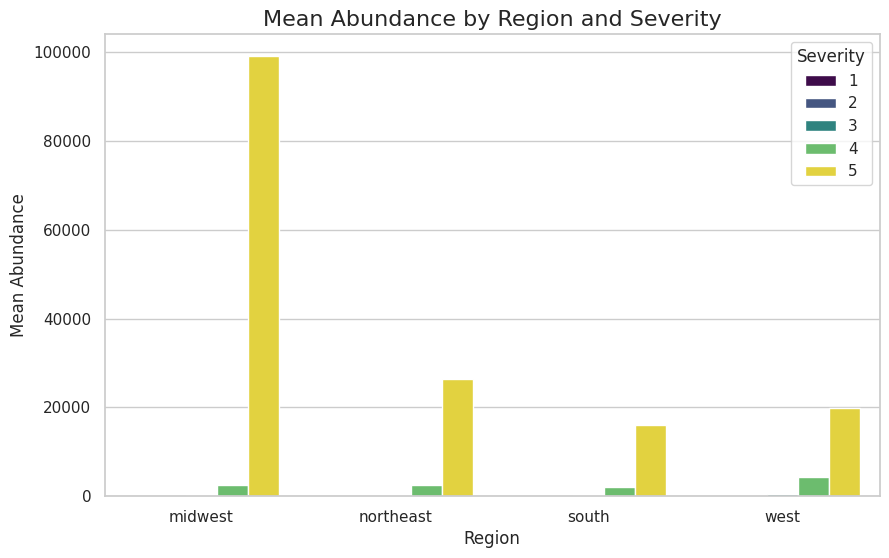

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#visualizing step/data analysis

#copying the training set
data = training_set.copy()

#showing what the data has
print("Data Info:\n")
data.info()

#basic stats
print("\nBasic Statistics:\n")
print(data.describe())

#checking for missing vals
print("\nMissing Values:\n")
print(data.isnull().sum())

#looking at all the unique values
print("\nUnique Values in Categorical Columns:\n")
for col in ['split', 'region', 'severity']:
    print(f"{col}: {data[col].unique()}")

#visualziing step
sns.set(style="whitegrid")

#showing the severity distribution (or if there is a concentration based on location)
plt.figure(figsize=(8, 5))
sns.countplot(data=training_set, x='severity', palette='viridis')
plt.title("Distribution of Severity Levels", fontsize=16)
plt.xlabel("Severity", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

#region-wise severity
plt.figure(figsize=(10, 6))
sns.boxplot(data=training_set, x='region', y='severity', palette='pastel')
plt.title("Region-wise Severity Distribution", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Severity", fontsize=12)
plt.show()

#abundance of blooms by severity
plt.figure(figsize=(8, 5))
sns.scatterplot(data=training_set, x='severity', y='abundance', hue='region', palette='deep')
plt.title("Abundance vs Severity", fontsize=16)
plt.xlabel("Severity", fontsize=12)
plt.ylabel("Abundance", fontsize=12)
plt.legend(title="Region")
plt.show()

#temporal distribution (basically just date distribution)
training_set['date'] = pd.to_datetime(training_set['date'])
training_set['year'] = training_set['date'].dt.year
plt.figure(figsize=(10, 6))
sns.histplot(training_set['year'], bins=10, kde=True, color="blue")
plt.title("Yearly Distribution of Data", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

#geographic visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(data=training_set, x='longitude', y='latitude', hue='region', palette='Set2', s=50)
plt.title("Geographical Distribution by Region", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(title="Region")
plt.show()

#correlation map
plt.figure(figsize=(10, 8))
corr = training_set[['latitude', 'longitude', 'severity', 'abundance']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

#group statistics (mean abundance for region and severity)
region_severity_group = training_set.groupby(['region', 'severity'])['abundance'].mean().reset_index()
print("\nMean Abundance by Region and Severity:\n")
print(region_severity_group)

#visualization of group statistics
plt.figure(figsize=(10, 6))
sns.barplot(data=region_severity_group, x='region', y='abundance', hue='severity', palette='viridis')
plt.title("Mean Abundance by Region and Severity", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Mean Abundance", fontsize=12)
plt.legend(title="Severity")
plt.show()
